In [ ]:
'''
archietectures of this file
1. Import s&p500 dataset from kaggle with relative dependencies
(dataset link: https://www.kaggle.com/datasets/camnugent/sandp500/data)
2. Train model with baseline models (Linear Regression Model and ARIMA) and LSTM model
3. Inference to predict the stock price of the next day
'''

# Import S&P500 dataset and relative dependencies

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("camnugent/sandp500")

print("Path to dataset files:", path)

/Users/eshan/PycharmProjects/FastAPIProject2/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/eshan/.cache/kagglehub/datasets/camnugent/sandp500/versions/4


In [2]:
import pandas as pd
# Load the S&P 500 dataset
df_sp500 = pd.read_csv(path + "/all_stocks_5yr.csv")
# Display the first few rows of the dataset
df_sp500.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [3]:
df_sp500

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS


# Preview S&P500 Dataset

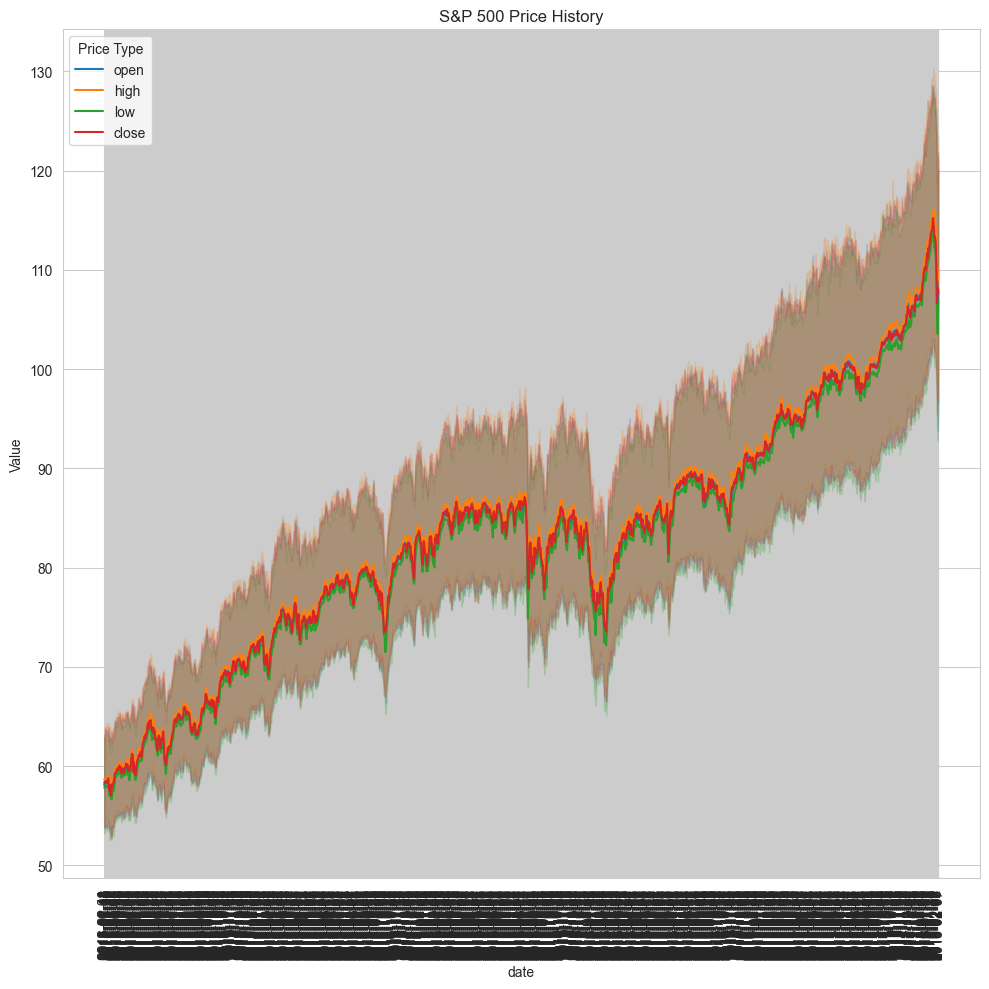

In [21]:
# visualize the data
import matplotlib.pyplot as plt
import seaborn as sns

# melt the dataframe to long format for multiple lines
melted = pd.melt(
    df_sp500,
    id_vars=["date", "Name"],
    value_vars=["open", "high", "low", "close"],
    var_name="Price Type",
    value_name="Value"
)


plt.figure(figsize=(10, 10))
sns.lineplot(data=melted, x="date", y ="Value", hue="Price Type")
plt.title("S&P 500 Price History")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Normalize stock trend
- scale_data: scaled stock generally
- scale_per_ticker: scale stock based on tickers

In [7]:
from sklearn.preprocessing import MinMaxScaler
def scale_data(df, columns):
    scaler = MinMaxScaler()
    scaled_value = scaler.fit_transform(df[columns])
    scaled_df = pd.DataFrame(scaled_value, columns=columns, index=df.index)
    result_df = df.copy()
    result_df[columns] = scaled_df

    return result_df

In [8]:
scale_df = scale_data(df_sp500, columns=['open', 'high', 'low', 'close','volume']) # without 'close' to avoid data leakage
scale_df


,date,open,high,low,close,volume,Name
0,2013-02-08,0.006585,0.006500,0.006456,0.006428,0.013599,AAL
1,2013-02-11,0.006497,0.006446,0.006275,0.006286,0.014367,AAL
2,2013-02-12,0.006282,0.006204,0.006196,0.006193,0.013144,AAL
3,2013-02-13,0.006208,0.006412,0.006270,0.006384,0.016595,AAL
4,2013-02-14,0.006522,0.006422,0.005734,0.006056,0.051566,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,0.036830,0.037061,0.036974,0.037232,0.004824,ZTS
619036,2018-02-02,0.037167,0.036989,0.036993,0.036724,0.004198,ZTS
619037,2018-02-05,0.036732,0.036408,0.035248,0.035284,0.004791,ZTS
619038,2018-02-06,0.034822,0.035266,0.034731,0.035010,0.007965,ZTS


In [47]:
import joblib
import os

def save_scaler(scaler , save_dir, name):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"scaler_{name}.pkl")
    joblib.dump(scaler, save_path)
    print(f"Scaler for {name} saved to {save_path}.")

# Scaled per ticker
def scale_per_ticker(df, save_dir, columns,group_col="Name"):
    result_df = df.copy()
    result_df[columns] = result_df[columns].astype(float)

    for name, group in df.groupby(group_col):
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(group[columns])
        result_df.loc[group.index, columns] = scaled
        save_scaler(scaler, save_dir, name)
    return result_df




In [48]:
save_dir = "save_scaler"
os.makedirs(save_dir, exist_ok=True)

scaled_df = scale_per_ticker(df_sp500, save_dir=save_dir, columns=['open', 'high', 'low', 'close','volume'])
scaled_df

Scaler for A saved to save_scaler/scaler_A.pkl.
Scaler for AAL saved to save_scaler/scaler_AAL.pkl.
Scaler for AAP saved to save_scaler/scaler_AAP.pkl.
Scaler for AAPL saved to save_scaler/scaler_AAPL.pkl.
Scaler for ABBV saved to save_scaler/scaler_ABBV.pkl.
Scaler for ABC saved to save_scaler/scaler_ABC.pkl.
Scaler for ABT saved to save_scaler/scaler_ABT.pkl.
Scaler for ACN saved to save_scaler/scaler_ACN.pkl.
Scaler for ADBE saved to save_scaler/scaler_ADBE.pkl.
Scaler for ADI saved to save_scaler/scaler_ADI.pkl.
Scaler for ADM saved to save_scaler/scaler_ADM.pkl.
Scaler for ADP saved to save_scaler/scaler_ADP.pkl.
Scaler for ADS saved to save_scaler/scaler_ADS.pkl.
Scaler for ADSK saved to save_scaler/scaler_ADSK.pkl.
Scaler for AEE saved to save_scaler/scaler_AEE.pkl.
Scaler for AEP saved to save_scaler/scaler_AEP.pkl.
Scaler for AES saved to save_scaler/scaler_AES.pkl.
Scaler for AET saved to save_scaler/scaler_AET.pkl.
Scaler for AFL saved to save_scaler/scaler_AFL.pkl.
Scaler f

,date,open,high,low,close,volume,Name
0,2013-02-08,0.042278,0.037232,0.042794,0.038064,0.051718,AAL
1,2013-02-11,0.038335,0.034823,0.034590,0.031683,0.055196,AAL
2,2013-02-12,0.028697,0.023872,0.031042,0.027503,0.049654,AAL
3,2013-02-13,0.025411,0.033290,0.034368,0.036084,0.065294,AAL
4,2013-02-14,0.039430,0.033728,0.010200,0.021342,0.223784,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,0.942139,0.963926,0.947507,0.956084,0.064907,ZTS
619036,2018-02-02,0.955582,0.961016,0.948288,0.935964,0.055030,ZTS
619037,2018-02-05,0.938243,0.937742,0.879013,0.878893,0.064391,ZTS
619038,2018-02-06,0.862264,0.891971,0.858523,0.868060,0.114463,ZTS


In [40]:


save_scaler(save_dir)
print("Scaler saved.")

NameError: name 'scaler' is not defined

# Train Time-Series Model
- Baseline Models: Linear Regression, ARIMA
- LSTM

## Linear Regression

In [12]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df = df_sp500[df_sp500["Name"] == "AAPL"].copy()
df = df.sort_values("date")

df["target"] = df["close"].shift(-1) # Shift close price to create target variable
df.dropna(inplace=True)  # Drop the last row with NaN target
# Split into features and target
features = ['open', 'high', 'low', 'close', 'volume']
X = df[features]
y = df["target"]

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [14]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Linear Regression MSE: {mse:.2f}, R^2: {r2:.2f}")

Linear Regression MSE: 3.48, R^2: 0.98


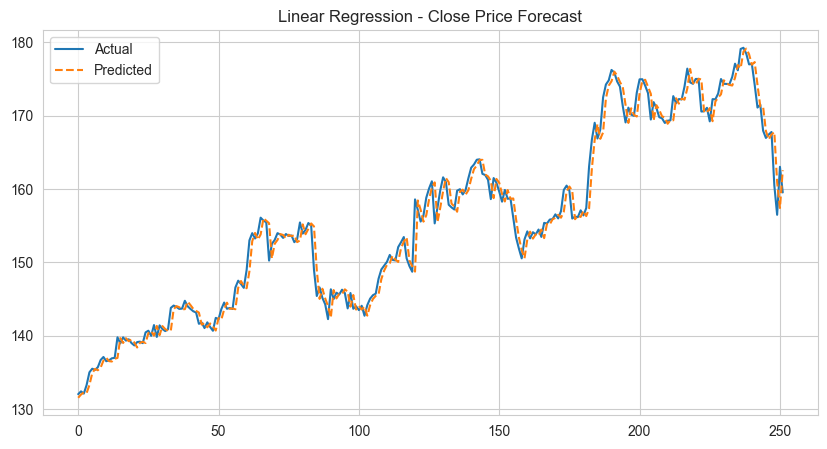

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted", linestyle="--")
plt.legend()
plt.title("Linear Regression - Close Price Forecast")
plt.show()

## ARIMA model

In [17]:
## ARIMA Model
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Use just the close prices
series = df["close"].copy()

# Split into train and test
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

In [18]:
# Fit ARIMA model (order: AR, differencing, MA)
model = ARIMA(train, order=(11, 2, 5))
model_fit = model.fit()

# Forecast the next 10 days
forecast = model_fit.forecast(steps=len(test))

/Users/eshan/PycharmProjects/FastAPIProject2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/eshan/PycharmProjects/FastAPIProject2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/eshan/PycharmProjects/FastAPIProject2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/eshan/PycharmProjects/FastAPIP

In [19]:
from sklearn.metrics import mean_squared_error
mse_arima = mean_squared_error(test, forecast)
print(f"ARIMA MSE: {mse_arima:.2f}")

ARIMA MSE: 370.24


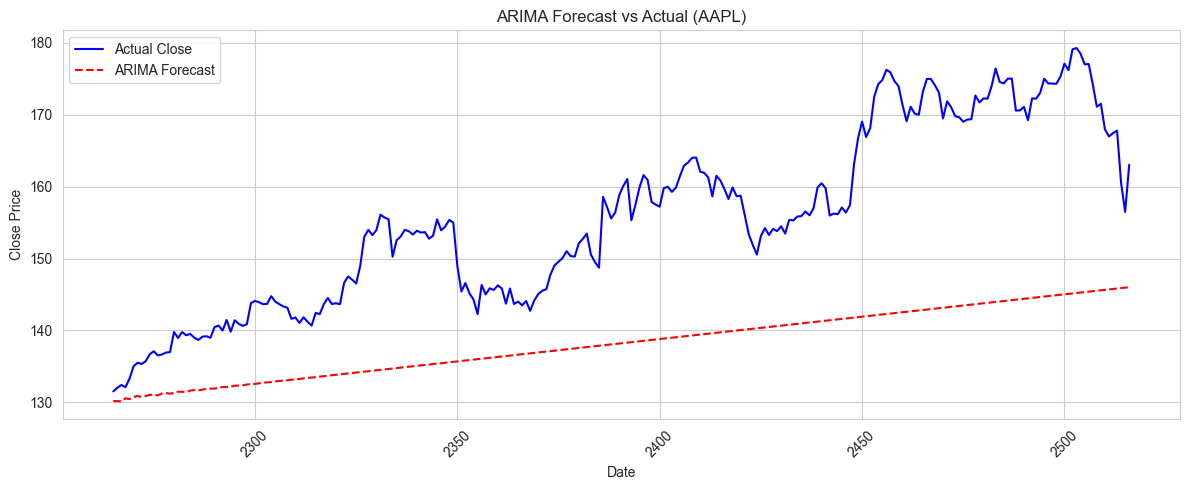

In [20]:
plt.figure(figsize=(12, 5))

# Plot original series
plt.plot(series.index[train_size:], test.values, label="Actual Close", color="blue")
plt.plot(series.index[train_size:], forecast, label="ARIMA Forecast", color="red", linestyle="--")

plt.title("ARIMA Forecast vs Actual (AAPL)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## LSTM model

In [22]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# use the "scaled by ticker data" to train a time-series model
train_df = scaled_df.copy()
train_df = train_df[train_df["Name"] == "ZTS"].sort_values("date")

train_df["date"] = pd.to_datetime(train_df["date"])
train_df.set_index("date", inplace=True)


In [23]:
# use scaled per tickers data
features = ['open', 'high', 'low', 'volume']
target = 'close'
scaled_df = pd.DataFrame(scaled_df, columns=features, index=scaled_df.index)

In [24]:
import numpy as np

def create_sequences(data, target, window_size=15):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i][features].values)
        y.append(data.iloc[i][target])
    return np.array(X), np.array(y)

In [25]:
X, y = create_sequences(scale_df, target)
len(X), len(y)
X.shape, y.shape

((619025, 15, 4), (619025,))

In [26]:
X[0], y[0]

(array([[0.00658545, 0.00649954, 0.0064565 , 0.01359914],
        [0.00649732, 0.0064463 , 0.00627456, 0.01436664],
        [0.00628189, 0.00620433, 0.00619588, 0.01314381],
        [0.00620844, 0.00641243, 0.00626964, 0.01659475],
        [0.0065218 , 0.00642211, 0.00573365, 0.05156577],
        [0.00602728, 0.00625272, 0.00611228, 0.02527831],
        [0.00622313, 0.00622852, 0.00618604, 0.01836575],
        [0.00614479, 0.00608334, 0.00572873, 0.02381803],
        [0.0058755 , 0.00593331, 0.00560579, 0.01928401],
        [0.00585102, 0.00576393, 0.00575823, 0.0098205 ],
        [0.00586571, 0.00584136, 0.00565497, 0.01162401],
        [0.00564048, 0.00567681, 0.00550745, 0.01523524],
        [0.00570903, 0.0057736 , 0.00574348, 0.01195414],
        [0.00581185, 0.00577844, 0.00584675, 0.00993728],
        [0.00575309, 0.00593331, 0.00581232, 0.01193198]]),
 np.float64(0.006012474296794487))

In [27]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert tp PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)
# Create a dataset and dataloader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [28]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, output_size)
        self._init_weights()

    def _init_weights(self):
        for name, param in self.lstm1.named_parameters():
            if "weight_ih" in name:
                nn.init.xavier_uniform_(param.data)
            elif "weight_hh" in name:
                nn.init.orthogonal_(param.data)
            elif "bias" in name:
                param.data.fill_(0)
                n = param.size(0)
                param.data[n//4:n//2].fill_(1)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)

    def forward(self, x):
        if torch.isnan(x).any():
            raise ValueError("Input contains NaN values")
        lstm_out, (h_n, _) = self.lstm1(x)
        last_hidden = h_n[-1]

        if last_hidden.size(0) > 1:
            last_hidden = self.batch_norm(last_hidden)

        last_hidden = self.dropout(last_hidden)

        last_hidden = torch.clamp(last_hidden, min=-10, max=10)
        output = self.fc1(last_hidden)
        output = self.fc1(last_hidden)
        output = torch.clamp(output, min=-1e6, max=1e6)

        if torch.isnan(output).any():
            print("Warning: NaN detected is output, replacing with zeros")
            output = torch.where(torch.isnan(output), torch.zeros_like(output), output)
        return output

def clip_gradients(model, max_norm=1.0):
    """Clip gradients to prevent explosion"""
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

def check_model_weights(model):
    """Check for NaN or inf in model weights"""
    for name, param in model.named_parameters():
        if torch.isnan(param).any() or torch.isinf(param).any():
            print(f"Warning: NaN/Inf found in {name}")
            return False
    return True

# Example usage with additional safety measures
def safe_training_step(model, criterion, optimizer, data, target):
    """Safe training step with NaN checking"""

    # Check input data
    if torch.isnan(data).any() or torch.isnan(target).any():
        print("Warning: NaN in input data, skipping batch")
        return None

    optimizer.zero_grad()

    # Forward pass
    output = model(data)

    # Compute loss with safety checks
    loss = criterion(output, target)

    if torch.isnan(loss) or torch.isinf(loss):
        print("Warning: NaN/Inf loss detected, skipping backward pass")
        return None

    # Backward pass
    loss.backward()

    # Check gradients
    if not check_model_weights(model):
        print("Warning: NaN in gradients, skipping optimizer step")
        return None

    # Clip gradients
    clip_gradients(model, max_norm=1.0)

    # Optimizer step
    optimizer.step()

    return loss.item()

In [29]:
import torch
import torch.nn as nn


# Create model with proper parameter order
model = LSTMModel(
    input_size=len(features),
    output_size=1,  # Specify output_size explicitly
    hidden_size=64,
    num_layers=2,
    dropout=0.2  # Optional: add dropout for better stability
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Add learning rate scheduler for better training stability
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

print("Starting training with NaN-safe LSTM model...")

for epoch in range(10):
    model.train()  # Set model to training mode
    epoch_losses = []
    nan_batches = 0

    for batch_idx, (xb, yb) in enumerate(dataloader):
        # Input validation (the model will also check this)
        if torch.isnan(xb).any() or torch.isnan(yb).any():
            print(f"Warning: NaN in input data at batch {batch_idx}, skipping...")
            nan_batches += 1
            continue

        # Use the safe training step function
        loss_value = safe_training_step(model, criterion, optimizer, xb, yb)

        if loss_value is None:
            print(f"Warning: Training step failed at batch {batch_idx}")
            nan_batches += 1
            continue

        epoch_losses.append(loss_value)

        # Optional: Print progress every 100 batches
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss_value:.6f}")

    # Calculate average loss for the epoch
    if epoch_losses:
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        print(f"Epoch {epoch+1}/10 completed:")
        print(f"  Average Loss: {avg_loss:.6f}")
        print(f"  Processed batches: {len(epoch_losses)}")
        if nan_batches > 0:
            print(f"  Skipped batches (NaN): {nan_batches}")

        # Update learning rate scheduler
        scheduler.step(avg_loss)

        current_lr = optimizer.param_groups[0]['lr']
        print(f" Current Learning Rate: {current_lr:.2e}")

        # Check model health
        if not check_model_weights(model):
            print("ERROR: Model weights corrupted with NaN/Inf. Stopping training.")
            break

    else:
        print(f"Epoch {epoch+1}/10: All batches failed! Stopping training.")
        break

    print("-" * 50)

print("Training completed!")

# Final model evaluation
print("\nFinal model evaluation...")
model.eval()
with torch.no_grad():
    total_loss = 0
    num_batches = 0

    for xb, yb in dataloader:
        if torch.isnan(xb).any() or torch.isnan(yb).any():
            continue

        pred = model(xb)
        if not torch.isnan(pred).any():
            loss = criterion(pred, yb)
            if not torch.isnan(loss):
                total_loss += loss.item()
                num_batches += 1

    if num_batches > 0:
        final_avg_loss = total_loss / num_batches
        print(f"Final average validation loss: {final_avg_loss:.6f}")
    else:
        print("No valid batches for final evaluation")

# Check final model state
if check_model_weights(model):
    print("✓ Final model weights are healthy")
else:
    print("✗ Final model weights contain NaN/Inf")

Starting training with NaN-safe LSTM model...
Epoch 1, Batch 0, Loss: 0.620704


/Users/eshan/PycharmProjects/FastAPIProject2/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Batch 100, Loss: 0.157813
Epoch 1, Batch 200, Loss: 0.397501
Epoch 1, Batch 300, Loss: 0.179358
Epoch 1, Batch 400, Loss: 0.231736
Epoch 1, Batch 500, Loss: 0.387844
Epoch 1, Batch 600, Loss: 0.556689
Epoch 1, Batch 700, Loss: 0.922931
Epoch 1, Batch 800, Loss: 0.176013
Epoch 1, Batch 900, Loss: 0.231519
Epoch 1, Batch 1000, Loss: 0.225864
Epoch 1, Batch 1100, Loss: 0.682498
Epoch 1, Batch 1200, Loss: 0.174656
Epoch 1, Batch 1300, Loss: 0.143696
Epoch 1, Batch 1400, Loss: 0.316398
Epoch 1, Batch 1500, Loss: 0.110150
Epoch 1, Batch 1600, Loss: 0.143103
Epoch 1, Batch 1700, Loss: 0.048450
Epoch 1, Batch 1800, Loss: 0.083332
Epoch 1, Batch 1900, Loss: 0.052168
Epoch 1, Batch 2000, Loss: 0.094110
Epoch 1, Batch 2100, Loss: 0.054980
Epoch 1, Batch 2200, Loss: 0.033005
Epoch 1, Batch 2300, Loss: 0.083600
Epoch 1, Batch 2400, Loss: 0.022723
Epoch 1, Batch 2500, Loss: 0.026819
Epoch 1, Batch 2600, Loss: 0.031200
Epoch 1, Batch 2700, Loss: 0.019406
Epoch 1, Batch 2800, Loss: 0.010747
E

/Users/eshan/PycharmProjects/FastAPIProject2/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2, Batch 100, Loss: 0.001112
Epoch 2, Batch 200, Loss: 0.000971
Epoch 2, Batch 300, Loss: 0.000587
Epoch 2, Batch 400, Loss: 0.001524
Epoch 2, Batch 500, Loss: 0.008883
Epoch 2, Batch 600, Loss: 0.001023
Epoch 2, Batch 700, Loss: 0.005160
Epoch 2, Batch 800, Loss: 0.000743
Epoch 2, Batch 900, Loss: 0.002701
Epoch 2, Batch 1000, Loss: 0.000631
Epoch 2, Batch 1100, Loss: 0.001251
Epoch 2, Batch 1200, Loss: 0.004259
Epoch 2, Batch 1300, Loss: 0.000574
Epoch 2, Batch 1400, Loss: 0.000791
Epoch 2, Batch 1500, Loss: 0.007724
Epoch 2, Batch 1600, Loss: 0.000721
Epoch 2, Batch 1700, Loss: 0.000885
Epoch 2, Batch 1800, Loss: 0.000831
Epoch 2, Batch 1900, Loss: 0.000434
Epoch 2, Batch 2000, Loss: 0.002310
Epoch 2, Batch 2100, Loss: 0.000805
Epoch 2, Batch 2200, Loss: 0.000680
Epoch 2, Batch 2300, Loss: 0.004647
Epoch 2, Batch 2400, Loss: 0.000990
Epoch 2, Batch 2500, Loss: 0.003901
Epoch 2, Batch 2600, Loss: 0.002367
Epoch 2, Batch 2700, Loss: 0.005525
Epoch 2, Batch 2900, Loss: 0.000522
E

# EarlyStopping

In [33]:
import torch
import torch.nn as nn
import numpy as np
import os
from datetime import datetime

In [34]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        """Save model when validation loss decreases."""
        self.best_weights = model.state_dict().copy()

In [36]:
# Model saving utilities
def save_model(model, optimizer, epoch, loss, filepath, scheduler=None):
    """Save complete model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'timestamp': datetime.now().isoformat()
    }
    if scheduler is not None:
        checkpoint['scheduler_state_dict'] = scheduler.state_dict()

    torch.save(checkpoint, filepath)
    print(f"✅ Model saved to {filepath}")

In [35]:
def load_model(model, optimizer, filepath, scheduler=None):
    """Load model checkpoint"""
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    if scheduler is not None and 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"✅ Model loaded from {filepath}")
    print(f"   Resumed from epoch {epoch}, loss: {loss:.6f}")
    return epoch, loss

In [37]:


# Create model with proper parameter order
model = LSTMModel(
    input_size=len(features),
    output_size=1,  # Specify output_size explicitly
    hidden_size=64,
    num_layers=2,
    dropout=0.2  # Optional: add dropout for better stability
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Add learning rate scheduler for better training stability
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

# Initialize early stopping
early_stopping = EarlyStopping(patience=7, min_delta=1e-6)

# Create directories for saving models
save_dir = 'model_checkpoints'
os.makedirs(save_dir, exist_ok=True)

# Training history tracking
train_losses = []
best_loss = float('inf')
start_epoch = 0

# Check if there's a checkpoint to resume from
checkpoint_path = os.path.join(save_dir, 'latest_checkpoint_0605.pth')
if os.path.exists(checkpoint_path):
    print(f"Found checkpoint at {checkpoint_path}")
    try:
        start_epoch, _ = load_model(model, optimizer, checkpoint_path, scheduler)
        start_epoch += 1  # Start from next epoch
        print(f"Resuming training from epoch {start_epoch}")
    except Exception as e:
        print(f"Failed to load checkpoint: {e}")
        print("Starting training from scratch...")
        start_epoch = 0

print("Starting enhanced training with NaN-safe LSTM model...")
print(f"Models will be saved to: {save_dir}")
print(f"Training from epoch {start_epoch + 1} to {start_epoch + 10}")

for epoch in range(start_epoch, start_epoch + 10):
    model.train()  # Set model to training mode
    epoch_losses = []
    nan_batches = 0

    print(f"\n📊 Epoch {epoch+1}/{start_epoch + 10}")

    for batch_idx, (xb, yb) in enumerate(dataloader):
        # Input validation (the model will also check this)
        if torch.isnan(xb).any() or torch.isnan(yb).any():
            print(f"⚠️  Warning: NaN in input data at batch {batch_idx}, skipping...")
            nan_batches += 1
            continue

        # Use the safe training step function
        loss_value = safe_training_step(model, criterion, optimizer, xb, yb)

        if loss_value is None:
            print(f"⚠️  Warning: Training step failed at batch {batch_idx}")
            nan_batches += 1
            continue

        epoch_losses.append(loss_value)

        # Optional: Print progress every 100 batches
        if batch_idx % 100 == 0 and batch_idx > 0:
            current_avg = sum(epoch_losses[-100:]) / min(100, len(epoch_losses))
            print(f"   Batch {batch_idx}: Current Loss: {loss_value:.6f}, Avg(last 100): {current_avg:.6f}")

    # Calculate average loss for the epoch
    if epoch_losses:
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(avg_loss)

        print(f"✅ Epoch {epoch+1} completed:")
        print(f"   Average Loss: {avg_loss:.6f}")
        print(f"   Processed batches: {len(epoch_losses)}")
        if nan_batches > 0:
            print(f"   Skipped batches (NaN): {nan_batches}")

        # Update learning rate scheduler
        scheduler.step(avg_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"   Current Learning Rate: {current_lr:.2e}")

        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_path = os.path.join(save_dir, 'best_model_0605.pth')
            save_model(model, optimizer, epoch, avg_loss, best_model_path, scheduler)
            print(f"   🏆 New best model! Loss: {avg_loss:.6f}")

            # Try to make a prediction with the best model
            try:
                model.eval()
                with torch.no_grad():
                    # Get a sample from the dataloader for prediction demo
                    sample_batch = next(iter(dataloader))
                    sample_x, sample_y = sample_batch
                    if not torch.isnan(sample_x).any():
                        pred = model(sample_x[:1])  # Predict for first sample
                        print(f"   🎯 Sample prediction: {pred.item():.6f} (target: {sample_y[0].item():.6f})")
                model.train()
            except Exception as e:
                print(f"   ⚠️  Prediction demo failed: {e}")

        # Save checkpoint every epoch
        checkpoint_path = os.path.join(save_dir, 'latest_checkpoint_0605.pth')
        save_model(model, optimizer, epoch, avg_loss, checkpoint_path, scheduler)

        # Check model health
        if not check_model_weights(model):
            print("❌ ERROR: Model weights corrupted with NaN/Inf. Stopping training.")
            break

        # Early stopping check
        if early_stopping(avg_loss, model):
            print(f"\n🛑 Early stopping triggered after epoch {epoch+1}")
            print(f"   Best loss achieved: {best_loss:.6f}")
            break

    else:
        print(f"❌ Epoch {epoch+1}: All batches failed! Stopping training.")
        break

    print("-" * 60)



print("\n🎉 Training completed!")


# Load best model for final evaluation
best_model_path = os.path.join(save_dir, 'best_model_0605.pth')
if os.path.exists(best_model_path):
    print("\n🔄 Loading best model for final evaluation...")
    load_model(model, optimizer, best_model_path, scheduler)

# Final model evaluation
print("\n📈 Final model evaluation...")
model.eval()
with torch.no_grad():
    total_loss = 0
    num_batches = 0
    predictions = []
    targets = []

    for xb, yb in dataloader:
        if torch.isnan(xb).any() or torch.isnan(yb).any():
            continue

        pred = model(xb)
        if not torch.isnan(pred).any():
            loss = criterion(pred, yb)
            if not torch.isnan(loss):
                total_loss += loss.item()
                num_batches += 1

                # Store some predictions for analysis
                if len(predictions) < 10:
                    predictions.extend(pred.cpu().numpy().flatten()[:5])
                    targets.extend(yb.cpu().numpy().flatten()[:5])

    if num_batches > 0:
        final_avg_loss = total_loss / num_batches
        print(f"✅ Final average validation loss: {final_avg_loss:.6f}")
        print(f"   Evaluated on {num_batches} batches")

        # Show some sample predictions vs targets
        if predictions and targets:
            print("\n📊 Sample Predictions vs Targets:")
            for i, (pred, target) in enumerate(zip(predictions[:5], targets[:5])):
                diff = abs(pred - target)
                print(f"   Sample {i+1}: Pred={pred:.6f}, Target={target:.6f}, Diff={diff:.6f}")
    else:
        print("❌ No valid batches for final evaluation")

# Check final model state
if check_model_weights(model):
    print("✅ Final model weights are healthy")
else:
    print("❌ Final model weights contain NaN/Inf")

# Training summary
print(f"\n📋 Training Summary:")
print(f"   Total epochs completed: {len(train_losses)}")
print(f"   Best training loss: {min(train_losses) if train_losses else 'N/A':.6f}")
print(f"   Final training loss: {train_losses[-1] if train_losses else 'N/A':.6f}")
print(f"   Models saved in: {save_dir}")

# Save final model
final_model_path = os.path.join(save_dir, 'final_model.pth')
if train_losses:
    save_model(model, optimizer, len(train_losses)-1, train_losses[-1], final_model_path, scheduler)

print(f"\n💾 Saved models:")
print(f"   • Best model: {os.path.join(save_dir, 'best_model.pth')}")
print(f"   • Final model: {final_model_path}")
print(f"   • Latest checkpoint: {os.path.join(save_dir, 'latest_checkpoint.pth')}")

# Prediction function for future use
def make_prediction_with_saved_model(model_path, input_data, scaler=None, features=None):
    """
    Make predictions using a saved model

    Args:
        model_path: Path to saved model
        input_data: Input sequence for prediction
        scaler: Optional scaler for inverse transform
        features: Optional feature list for scaler
    """
    # Load model
    checkpoint = torch.load(model_path)

    # Create new model instance (you'll need to adjust parameters as needed)
    pred_model = LSTMModel(
        input_size=input_data.shape[-1] if len(input_data.shape) > 1 else len(features),
        output_size=1,
        hidden_size=64,
        num_layers=2,
        dropout=0.2
    )

    pred_model.load_state_dict(checkpoint['model_state_dict'])
    pred_model.eval()

    with torch.no_grad():
        if not isinstance(input_data, torch.Tensor):
            input_data = torch.tensor(input_data, dtype=torch.float32)

        if len(input_data.shape) == 2:
            input_data = input_data.unsqueeze(0)  # Add batch dimension

        prediction = pred_model(input_data).item()

        # Inverse transform if scaler provided
        if scaler is not None and features is not None:
            dummy = np.zeros((1, len(features) + 1))
            dummy[0, -1] = prediction
            actual_prediction = scaler.inverse_transform(dummy)[0, -1]
            return actual_prediction, prediction

        return prediction

print(f"\n🎯 To make predictions later, use:")
print(f"   prediction = make_prediction_with_saved_model('{best_model_path}', your_input_data)")
print(f"   # Or with inverse scaling:")
print(f"   actual_price, norm_pred = make_prediction_with_saved_model('{best_model_path}', your_input_data, scaler, features)")

Starting enhanced training with NaN-safe LSTM model...
Models will be saved to: model_checkpoints
Training from epoch 1 to 10

📊 Epoch 1/10
⚠️  Warning: NaN in input data at batch 2, skipping...


/Users/eshan/PycharmProjects/FastAPIProject2/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️  Warning: NaN in input data at batch 81, skipping...
⚠️  Warning: NaN in input data at batch 95, skipping...
   Batch 100: Current Loss: 0.225889, Avg(last 100): 0.655115
⚠️  Warning: NaN in input data at batch 112, skipping...
⚠️  Warning: NaN in input data at batch 132, skipping...
   Batch 200: Current Loss: 0.587237, Avg(last 100): 0.475021
⚠️  Warning: NaN in input data at batch 249, skipping...
   Batch 300: Current Loss: 0.160091, Avg(last 100): 0.481718
⚠️  Warning: NaN in input data at batch 304, skipping...
⚠️  Warning: NaN in input data at batch 352, skipping...
⚠️  Warning: NaN in input data at batch 363, skipping...
   Batch 400: Current Loss: 0.373992, Avg(last 100): 0.403963
⚠️  Warning: NaN in input data at batch 414, skipping...
⚠️  Warning: NaN in input data at batch 421, skipping...
⚠️  Warning: NaN in input data at batch 469, skipping...
   Batch 500: Current Loss: 0.317892, Avg(last 100): 0.411131
⚠️  Warning: NaN in input data at batch 523, skipping...
⚠️  Warn

/Users/eshan/PycharmProjects/FastAPIProject2/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


⚠️  Warning: NaN in input data at batch 59, skipping...
   Batch 100: Current Loss: 0.001944, Avg(last 100): 0.001971
⚠️  Warning: NaN in input data at batch 106, skipping...
⚠️  Warning: NaN in input data at batch 119, skipping...
⚠️  Warning: NaN in input data at batch 169, skipping...
   Batch 200: Current Loss: 0.000954, Avg(last 100): 0.002032
⚠️  Warning: NaN in input data at batch 254, skipping...
⚠️  Warning: NaN in input data at batch 261, skipping...
   Batch 300: Current Loss: 0.003029, Avg(last 100): 0.002480
⚠️  Warning: NaN in input data at batch 347, skipping...
⚠️  Warning: NaN in input data at batch 351, skipping...
⚠️  Warning: NaN in input data at batch 364, skipping...
   Batch 400: Current Loss: 0.000515, Avg(last 100): 0.002606
⚠️  Warning: NaN in input data at batch 426, skipping...
⚠️  Warning: NaN in input data at batch 453, skipping...
   Batch 500: Current Loss: 0.012934, Avg(last 100): 0.002187
⚠️  Warning: NaN in input data at batch 541, skipping...
   Batc

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import joblib

joblib.dump(scaler, os.path.join(save_dir, 'scaler.pkl'))

# Inference
## Predict the stock performance of the next day

In [50]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Create 60 sequential dates
dates = pd.date_range(end=pd.Timestamp.today(), periods=60)

# Simulate mock stock data
data = {
    "date": dates,
    "open": np.round(np.random.uniform(100, 200, size=60), 2),
    "high": np.round(np.random.uniform(200, 220, size=60), 2),
    "low": np.round(np.random.uniform(90, 100, size=60), 2),
    "close": np.round(np.random.uniform(100, 200, size=60), 2),
    "volume": np.random.randint(1_000_000, 5_000_000, size=60)
}

# Create DataFrame
df = pd.DataFrame(data)
df.set_index("date", inplace=True)

# Save to CSV
df.to_csv("mock_ticker_data.csv")

print("Mock ticker_data.csv created with 60 rows.")


Mock ticker_data.csv created with 60 rows.


In [94]:
import pandas as pd
import numpy as np

# Configuration
n_rows = 60
ticker = "NVDA"
start_date = pd.Timestamp("2024-01-02 05:00:00")

# Generate dates
dates = pd.date_range(start=start_date, periods=n_rows, freq='B')  # business days only

# Generate mock stock data
np.random.seed(42)
close_prices = np.round(np.random.uniform(200, 300, size=n_rows), 2)
open_prices = close_prices + np.round(np.random.normal(0, 2, size=n_rows), 2)
highs = np.maximum(open_prices, close_prices) + np.round(np.random.uniform(1, 5, size=n_rows), 2)
lows = np.minimum(open_prices, close_prices) - np.round(np.random.uniform(1, 5, size=n_rows), 2)
vws = (highs + lows + close_prices) / 3  # volume weighted approx
volumes = np.random.randint(80_000_000, 150_000_000, size=n_rows)
n_vals = np.random.randint(1_000_000, 2_000_000, size=n_rows)

# Assemble DataFrame
df = pd.DataFrame({
    "volume": volumes.astype(int),
    "vw": vws,
    "open": open_prices,
    "close": close_prices,
    "high": highs,
    "low": lows,
    "date": dates,
    "n": n_vals,
    "ticker": ticker
})

# Save to CSV
df.to_csv("NVDA.csv", index=False)
print("Mock dataset saved as 'NVDA.csv'")


Mock dataset saved as 'NVDA.csv'


In [ ]:
import os
os.getenv("SCALER_PATH")
os.getenv("MODEL_PATH")

In [73]:
import joblib
import torch
scaler_path = os.getenv("SCALER_PATH")
model_path = os.getenv("MODEL_PATH")
checkpoint_path = os.getenv("CHECKPOINT_PATH")
scaler = joblib.load(scaler_path)

# Recreate the archietecture
model = LSTMModel(
    input_size=len(features),
    output_size=1,  # Specify output_size explicitly
    hidden_size=64,
    num_layers=2,
    dropout=0.2  # Optional: add dropout for better stability
)

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Load weights
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

RuntimeError: Error(s) in loading state_dict for LSTMModel:
	size mismatch for lstm1.weight_ih_l0: copying a param with shape torch.Size([256, 4]) from checkpoint, the shape in current model is torch.Size([256, 5]).

In [74]:
features = ["open", "high", "low", "close", "volume"]

# Check all features exist before using them
missing = [col for col in features if col not in df.columns]
if missing:
    raise KeyError(f"Missing columns: {missing}")

# Scale or use features
X = df[features]

In [75]:
mock_data = os.getenv("MOCK_DATA_PATH")
df = pd.read_csv("../test_api/mock_ticker_data_tsla.csv", index_col=0)
features = ["open", "high", "low", "volume"]

n_steps = 60
recent_data = df[features].values[-n_steps:]

scaled_data = scaler.transform(recent_data)
input_tensor = torch.tensor(scaled_data, dtype=torch.float32).unsqueeze(0)


KeyError: "['volume'] not in index"

In [ ]:
# with torch.no_grad():
#     prediction = model(input_tensor)

In [ ]:
# predicted_scaled = prediction.numpy().reshape(-1, 1)
# predicted_real = scaler.inverse_transform(
#     np.concatenate([np.zeros((1, len(features) - 1)), predicted_scaled], axis=1)[0, -1]
# )
# print(f"Predicted next-day closing price: {predicted_real}")

In [ ]:
# def predict_next_day(df, model, scaler, features, n_steps):
#     recent_data = df[features].values[-n_steps:]
#     scaled = scaler.transform(recent_data)
#     x = torch.tensor(scaled, dtype=torch.float32).unsqueeze(0)
#
#     with torch.no_grad():
#         y_pred = model(x)
#
#     predicted_scaled = y_pred.numpy().reshape(-1, 1)
#     padded = np.concantenate

In [60]:
def load_model_2(model_path, feature_dim):
    # Create the model architecture
    model = LSTMModel(
        input_size=feature_dim,
        output_size=1,
        hidden_size=64,
        num_layers=2,
        dropout=0.2
    )
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model


In [88]:

def predict_next_day(df, features_for_scaler, features_for_model, model, scaler, target_index_in_scaler, n_steps=60):
# Use only the latest n_steps data
    df = df.copy()
    df[features_for_scaler] = df[features_for_scaler].astype(float)

    if len(df) < n_steps:
        raise ValueError("Not enough data to make prediction.")

    # all features scaled
    recent_data = df[features_for_scaler].values[-n_steps:]
    scaled_input = scaler.transform(recent_data)

    # select scaled features for train without target feature "close"
    model_input = scaled_input[:, [features_for_scaler.index(f) for f in features_for_model]]
    x = torch.tensor(model_input, dtype=torch.float32).unsqueeze(0)  # shape (1, n_steps, n_features)

    # Predict
    with torch.no_grad():
        pred = model(x).numpy().flatten()[0]

    # Inverse transform assuming 'close' is last column
    padded = np.zeros((1, len(features_for_scaler)))
    padded[0, target_index_in_scaler] = pred
    predicted_close = scaler.inverse_transform(padded)[0, target_index_in_scaler]
    return predicted_close



In [90]:
# Load ticker data
df = pd.read_csv("../test_api/mock_ticker_data.csv")

# Define your columns
features_for_scaler = ["open", "high", "low", "close", "volume"]
features_for_model = ["open", "high", "low", "volume"]
target_index = features_for_scaler.index("close")
ticker = "AAPL"  # or whatever you use

# Load model and scaler
scaler = joblib.load(f"save_scaler/scaler_{ticker}.pkl")
model = load_model_2("model_checkpoints/latest_checkpoint.pth", feature_dim=len(features))

# Make prediction
predicted_price = predict_next_day(df, features_for_scaler, features_for_model, model, scaler, target_index, n_steps)

if predicted_price is not None:
    print(f"Predicted next-day closing price for {ticker}: {predicted_price:.2f}")
else:
    print("Prediction failed")

Predicted next-day closing price for AAPL: 60.41


/Users/eshan/PycharmProjects/FastAPIProject2/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


# Predict next N days


In [ ]:
def predict_next_n_days(df, features_for_scaler, features_for_model, model, scaler, , target_index, n_steps=60):
    df = df.copy()
    df[features_for_scaler] = df[features_for_scaler].astype(float)
